In [29]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds
import delfi.kernel as dk

from delfi.simulator.BaseSimulator import BaseSimulator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from delfi.utils.viz import plot_pdf

from tqdm import tqdm_notebook as tqdm

from parameters import ParameterSet

%matplotlib notebook

import delfi.utils.viz as dv

In [251]:
params = ParameterSet({})

params.seed = 239

params.infer = ParameterSet({})
params.infer.n_components = 1
params.infer.n_hiddens = [10, 10]
params.infer.pilot_samples = 100
params.infer.svi = False
params.infer.prior_norm = True

params.run = ParameterSet({})
params.run.n_train = 50000
#params.run.minibatch = 100
params.run.epochs = 20
#params.run.lr = 0.02

In [252]:
prior_mean = 2
prior_var = 0.5

prop_prior_mean=1
prop_prior_var=0.05

noise_var = 0.01

gt = np.array([ 0.6 ])

In [253]:
def gauss(x, mean, cov):
    covi = np.linalg.inv(cov)
    dots = np.einsum('...i,ij,...j', x - mean, covi, x - mean)
    ret = 1 / np.sqrt(2 * np.pi * np.linalg.det(cov)) * np.exp(-0.5 * dots)
    assert ret.shape == x.shape[:-1]
    return ret

class ForwardModel(BaseSimulator):
    def __init__(self, seed=None):
        super().__init__(dim_param=1, seed=seed)
        self.noise_std = np.sqrt(noise_var)
    
    def gen_single(self, params):
        means = self.get_means(params)
        sample = means + self.noise_std * np.random.normal(size=params.shape)
        return { "data" :  np.array(sample) }
    
    def likelihood(self, x, params):
        means = self.get_means(params)
        diffs = means - x
        ret = gauss(diffs.reshape(-1,1), [0], (self.noise_std ** 2) * np.eye(1))
        return ret
        
    def get_means(self, params):
        return np.sign(params) * (np.abs(params) ** (1/3))
    
    def get_mle(self, params):
        return np.asarray(params) ** 3

In [254]:
m = ForwardModel(params.seed)
prior = dd.Gaussian(m=[prior_mean], S=[[prior_var]])
prop_prior = dd.Gaussian(m=[prop_prior_mean], S=[[prop_prior_var]])
s = ds.Identity(1)

g = dg.Default(m, prior, s)

xobs = m.get_means(gt)

res = infer.SNPE(generator=g, obs=[xobs], verbose=True, **params.infer)

logs, tds, posteriors = res.run(n_rounds=1, **params.run)

posterior = posteriors[-1]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [255]:
m = ForwardModel(params.seed)
prop_prior = dd.Gaussian(m=[prop_prior_mean], S=[[prop_prior_var]])
s = ds.Identity(1)

g = dg.Default(m, prop_prior, s)

xobs = m.get_means(gt)

res_uncorr = infer.SNPE(generator=g, obs=[xobs], verbose=True, **params.infer)

logs, tds, posteriors_uncorr = res_uncorr.run(n_rounds=1, **params.run)

posterior_uncorr = posteriors_uncorr[-1]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [258]:
m = ForwardModel(params.seed)
prior = dd.Gaussian(m=[prior_mean], S=[[prior_var]])
s = ds.Identity(1)

g = dg.Default(m, prior, s)

xobs = m.get_means(gt)

res_SNPE = infer.SNPE(generator=g, obs=[xobs], verbose=True, **params.infer)

params.run.n_train = 100000

logs, tds, posteriors_SNPE = res_SNPE.run(n_rounds=1, impute_proposal=prop_prior, **params.run)

posterior_SNPE = posteriors_SNPE[-1]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>


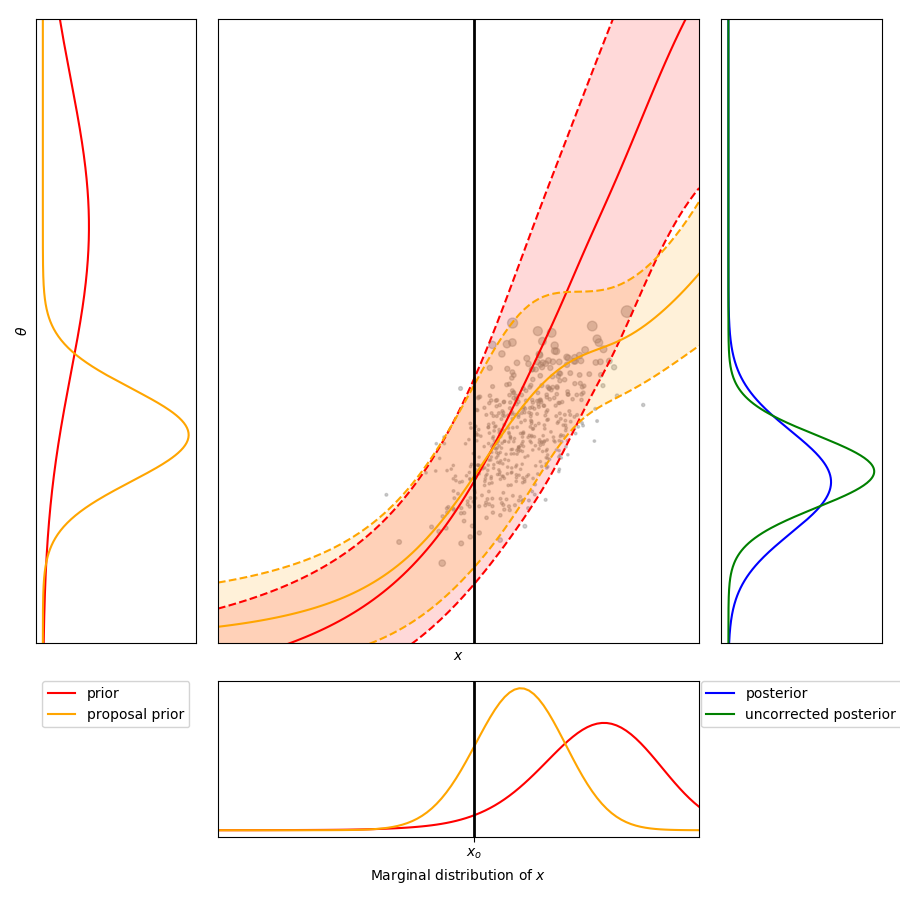

In [259]:
fig = plt.figure(figsize=(9,9))

###############################################################################
# sampling from proposal prior and running forward model
n_samp = 500
theta_samp = np.sqrt(prop_prior_var) * np.random.randn(n_samp) + prop_prior_mean
x_samp = np.sqrt(noise_var) * np.random.randn(n_samp) + m.get_means(theta_samp)

theta_lims = [0, 3]
thetas = np.linspace(theta_lims[0], theta_lims[1], 500)

xlims = [0, m.get_means(theta_lims[1]) * 1.1]

xs = np.linspace(xlims[0], xlims[1], 100)

posts = [ res.predict([[x]]) for x in xs ]
post_means = np.array([ post.xs[0].m[0] for post in posts ])
post_vars = np.array([ post.xs[0].S[0,0] for post in posts ])

posts_SNPE = [ res_SNPE.predict([[x]]) for x in xs ]
post_means_SNPE = np.array([ post.xs[0].m[0] for post in posts_SNPE ])
post_vars_SNPE = np.array([ post.xs[0].S[0,0] for post in posts_SNPE ])

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 3, 1], height_ratios=[4,1])

prior_col = "red"
prop_prior_col = "orange"
post_col = "blue"
post_uncorr_col = "green"

# LEFTHAND SIDE
axl = plt.subplot(gs[0,0])
#plt.plot(prop_prior, yy, '--',color='0.55', label='proposal prior')
plt.plot(prior.eval(thetas.reshape(-1,1), log=False), thetas, c=prior_col, label='prior')
plt.plot(prop_prior.eval(thetas.reshape(-1,1), log=False), thetas, c=prop_prior_col, label='proposal prior')

axl.set_ylim(theta_lims)
axl.set_yticks([])
axl.set_xticks([])
plt.ylabel(r'$\theta$')
axl.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  ncol=1)

axr = plt.subplot(gs[0,2])



# RIGHTHAND SIDE
plt.plot(posterior.eval(thetas.reshape(-1,1), log=False), thetas, c=post_col, label='posterior')
plt.plot(posterior_uncorr.eval(thetas.reshape(-1,1), log=False), thetas, c=post_uncorr_col, label='uncorrected posterior')
#    plt.plot(pp_post,yy,color=col_2, label='posterior')
#plt.plot(pp_param,yy,color=col_3, label='parametrised posterior')
axr.set_ylim(theta_lims)
#ax.set_xticks([])
axr.set_xticks([])
plt.ylabel('')
axr.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=1)
#plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right')


hl, ll = axl.get_legend_handles_labels()
hr, lr = axr.get_legend_handles_labels()
axr.set_yticks([])

axm = plt.subplot(gs[0,1])
plt.ylabel('')

iws = prior.eval(theta_samp.reshape(-1,1), log=False) / prop_prior.eval(theta_samp.reshape(-1,1), log=False)

# Draw true posterior
plt.scatter(x_samp, theta_samp, color='0.55', s=30 * np.log((1.1 - np.min(iws)) + iws), alpha=0.4)
#plt.plot(x0_grid, true_means, color = '0.0', label='true posterior')
#plt.plot(x0_grid, fake_means, color = col_0, label='true posterior')

#plt.plot(x0_grid,true_means + 2 * np.sqrt(true_covs),'--',color=col_0)
#plt.plot(x0_grid,true_means - 2 * np.sqrt(true_covs),'--',color=col_0)
#plt.fill_between(x0_grid,fake_means-2 * np.sqrt(fake_covs),
#                 fake_means+2 * np.sqrt(fake_covs),
#                 facecolor=col_0,
#                 alpha=0.15)

# Draw posterior means (in orange)
std_col = plt.get_cmap("tab10")(0)

std_col = prior_col

plt.plot(xs,post_means, c=std_col, label='posterior')
plt.plot(xs,post_means + 2 * np.sqrt(post_vars),ls='--', c=std_col)
plt.plot(xs,post_means - 2 * np.sqrt(post_vars),ls='--', c=std_col)

plt.fill_between(xs,post_means-2 * np.sqrt(post_vars),
                 post_means+2 * np.sqrt(post_vars), facecolor=std_col,
                 alpha=0.15)


std_col = prop_prior_col

plt.plot(xs,post_means_SNPE, c=std_col, label='SNPE')
plt.plot(xs,post_means_SNPE + 2 * np.sqrt(post_vars_SNPE),ls='--', c=std_col)
plt.plot(xs,post_means_SNPE - 2 * np.sqrt(post_vars_SNPE),ls='--', c=std_col)

plt.fill_between(xs,post_means_SNPE-2 * np.sqrt(post_vars_SNPE),
                 post_means_SNPE+2 * np.sqrt(post_vars_SNPE), facecolor=std_col,
                 alpha=0.15)

# Draw vertical lines around chosen point
axm.axvline(xobs,lw=2, c='k')
#     axm.vlines(obs_stats-eps, 0, axm.get_ylim()[1], lw=1, color='0.25')
#     axm.vlines(obs_stats+eps, 0, axm.get_ylim()[1], lw=1, color='0.25')

axm.set_xlim(xlims)
axm.set_ylim(theta_lims)
axm.set_xticks([])
axm.set_yticks([])
#plt.xlabel('x')
#plt.legend(bbox_to_anchor=(0.0, 1), loc='upper left')

#plt.xticks([xobs], [r'$x_{o}$'])

axm.set_xlabel("$x$")

axb = plt.subplot(gs[1,1])


def compute_marginals(prop):
    thetas = prop.gen(100000)
    means = m.get_means(thetas)
    
    ret = means + np.sqrt(noise_var) * np.random.normal(size=thetas.shape)
    return ret
    
prior_marg_samples = compute_marginals(prior)
prop_prior_marg_samples = compute_marginals(prop_prior)

from sklearn.neighbors.kde import KernelDensity

prior_marg_density = KernelDensity(kernel='gaussian', 
                                   bandwidth=0.05 * (xlims[1] - xlims[0])).fit(prior_marg_samples)
prop_prior_marg_density = KernelDensity(kernel='gaussian', 
                                       bandwidth=0.05 * (xlims[1] - xlims[0])).fit(prop_prior_marg_samples)

plt.plot(xs, np.exp(prior_marg_density.score_samples(xs.reshape(-1,1))), c=prior_col, label='prior')
plt.plot(xs, np.exp(prop_prior_marg_density.score_samples(xs.reshape(-1,1))), c=prop_prior_col, label='prioposal prior')

#plt.plot(xs, gen_mod.eval(xs.reshape(-1,1), log=False), color='0.0', label='marginal')

axb.set_xlim(xlims)
axb.set_xticks([])
plt.xticks([xobs], [r'$x_{o}$'])
axb.set_yticks([])

axb.set_xlabel("Marginal distribution of $x$")
#axb.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
 #          fancybox=True, shadow=True, ncol=1)

axb.axvline(xobs, lw=2, c='k')


plt.tight_layout()

plt.show()

In [260]:
np.savez_compressed("samples", theta_samp=theta_samp, x_samp=x_samp)